# Milestones 2

`Ridhwan Muttaqien - HCK06`

## URL Dataset & Deployment

- Dataset yang digunakan dapat diakses pada link berikut : https://www.kaggle.com/datasets/gpiosenka/coffee-bean-dataset-resized-224-x-224

- Hasil permodelan dapat dicoba dengan mengakses webapss pada link berikut : https://huggingface.co/spaces/Ridhwanm/h8dsft_P2M2_Ridhwan_Muttaqien

- Berikut disertakan link Google drive tempat model disimpan : https://drive.google.com/file/d/1HfE_oeYk5ubKxQ6AWgRvduib_oltWE5E/view?usp=sharing

## Description & Objective

Indonesia merupakan salah satu negara penghasil kopi terbesar di dunia, maka wajar jika konsumsi kopi di Indonesia pun juga besar. Berdasarkan data dari International Coffee Organization (ICO), konsumsi kopi di Indonesia memiliki tren kenaikan. Berikut kami tampilkan visualisasi data tersebut (sumber : https://dataindonesia.id/agribisnis-kehutanan/detail/berapa-konsumsi-kopi-indonesia-pada-20202021).

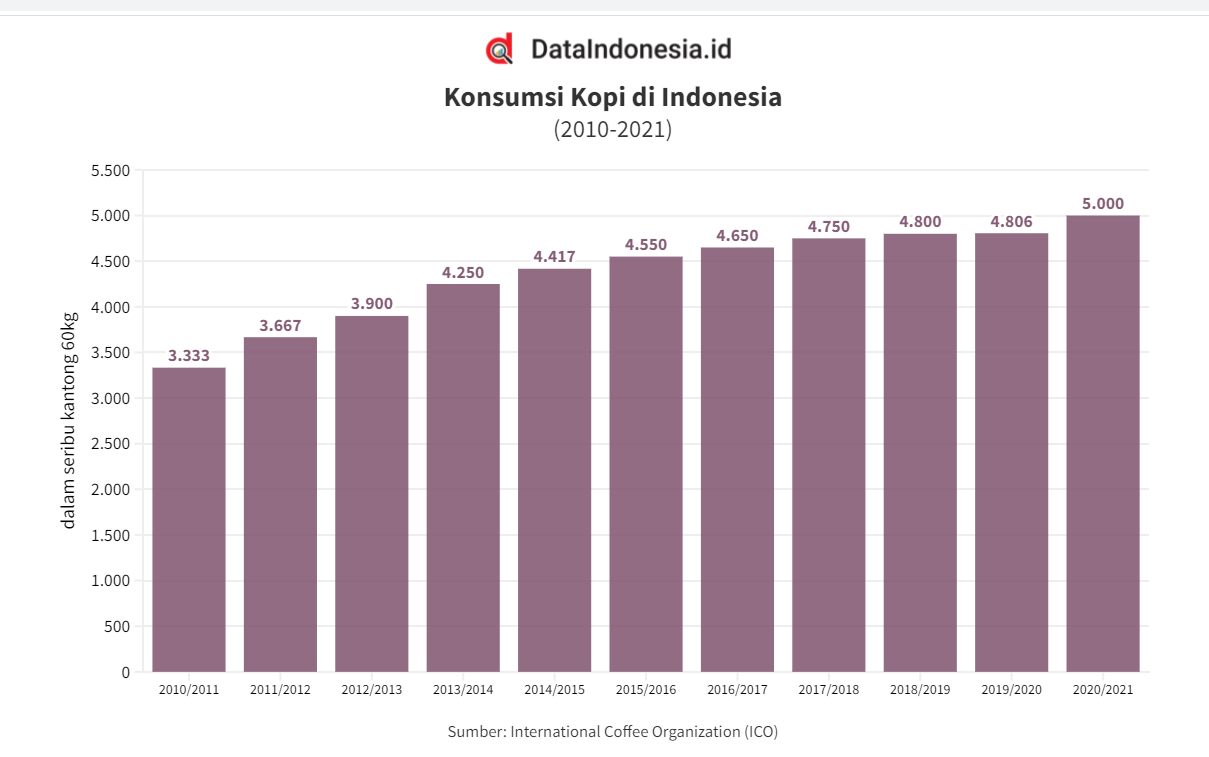

Saat ini kopi tidak lagi identik sebagai minuman orang tua, anak muda mulai keranjingan untuk menikmati minuman satu ini. Ini bisa dibuktikan dengan banyaknya cafe atau coffee shop yang bermunculan saat ini. Bahkan tidak jarang penikmat kopi yang menyeduh sendiri di rumah. Mereka hanya perlu memesan biji kopi yang sudah diroasting untuk kemudian digiling dan diseduh sendiri.

Tren menyeduh kopi mandiri ini meningkatkan jumlah penikmat kopi pemula yang baru mulai belajar untuk menikmati minuman pahit ini. Tidak jarang mereka membeli biji kopi tanpa tahu jenis roasting-nya. Milestones 2 ini akan membuat model yang dapat memprediksi jenis roasting pada biji kopi dan juga akan memberi rekomendasi jenis penyeduhan apa yang cocok untuk jenis roasting yang diprediksi. Model ini juga dapat digunakan untuk quality control pada perusahaan roastery kopi.

## Libraries Importing

In [1]:
from google.colab import files
!pip install -q kaggle
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json
import matplotlib.pyplot as plt
import numpy as np
import glob
import joblib
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

Saving kaggle.json to kaggle.json
kaggle.json
total 4
-rw------- 1 root root 72 Aug  5 01:39 kaggle.json
{"username":"ridhwanmuttaqien","key":"38e5f51bf1b12b193757cfe9e96058b2"}

## Data Loading & Exploratory Data Analysis

In [2]:
# download dataset dari kaggle

!kaggle datasets download -d gpiosenka/coffee-bean-dataset-resized-224-x-224

 98% 141M/144M [00:08<00:00, 17.2MB/s]
100% 144M/144M [00:08<00:00, 18.1MB/s]


In [3]:
# extract dataset yang sudah di download

!unzip -q /content/coffee-bean-dataset-resized-224-x-224.zip

In [4]:
# mengakses file pada direktori dataset

dark_files = glob.glob('/content/train/Dark/*')
green_files = glob.glob('/content/train/Green/*')
light_files = glob.glob('/content/train/Light/*')
medium_files = glob.glob('/content/train/Medium/*')

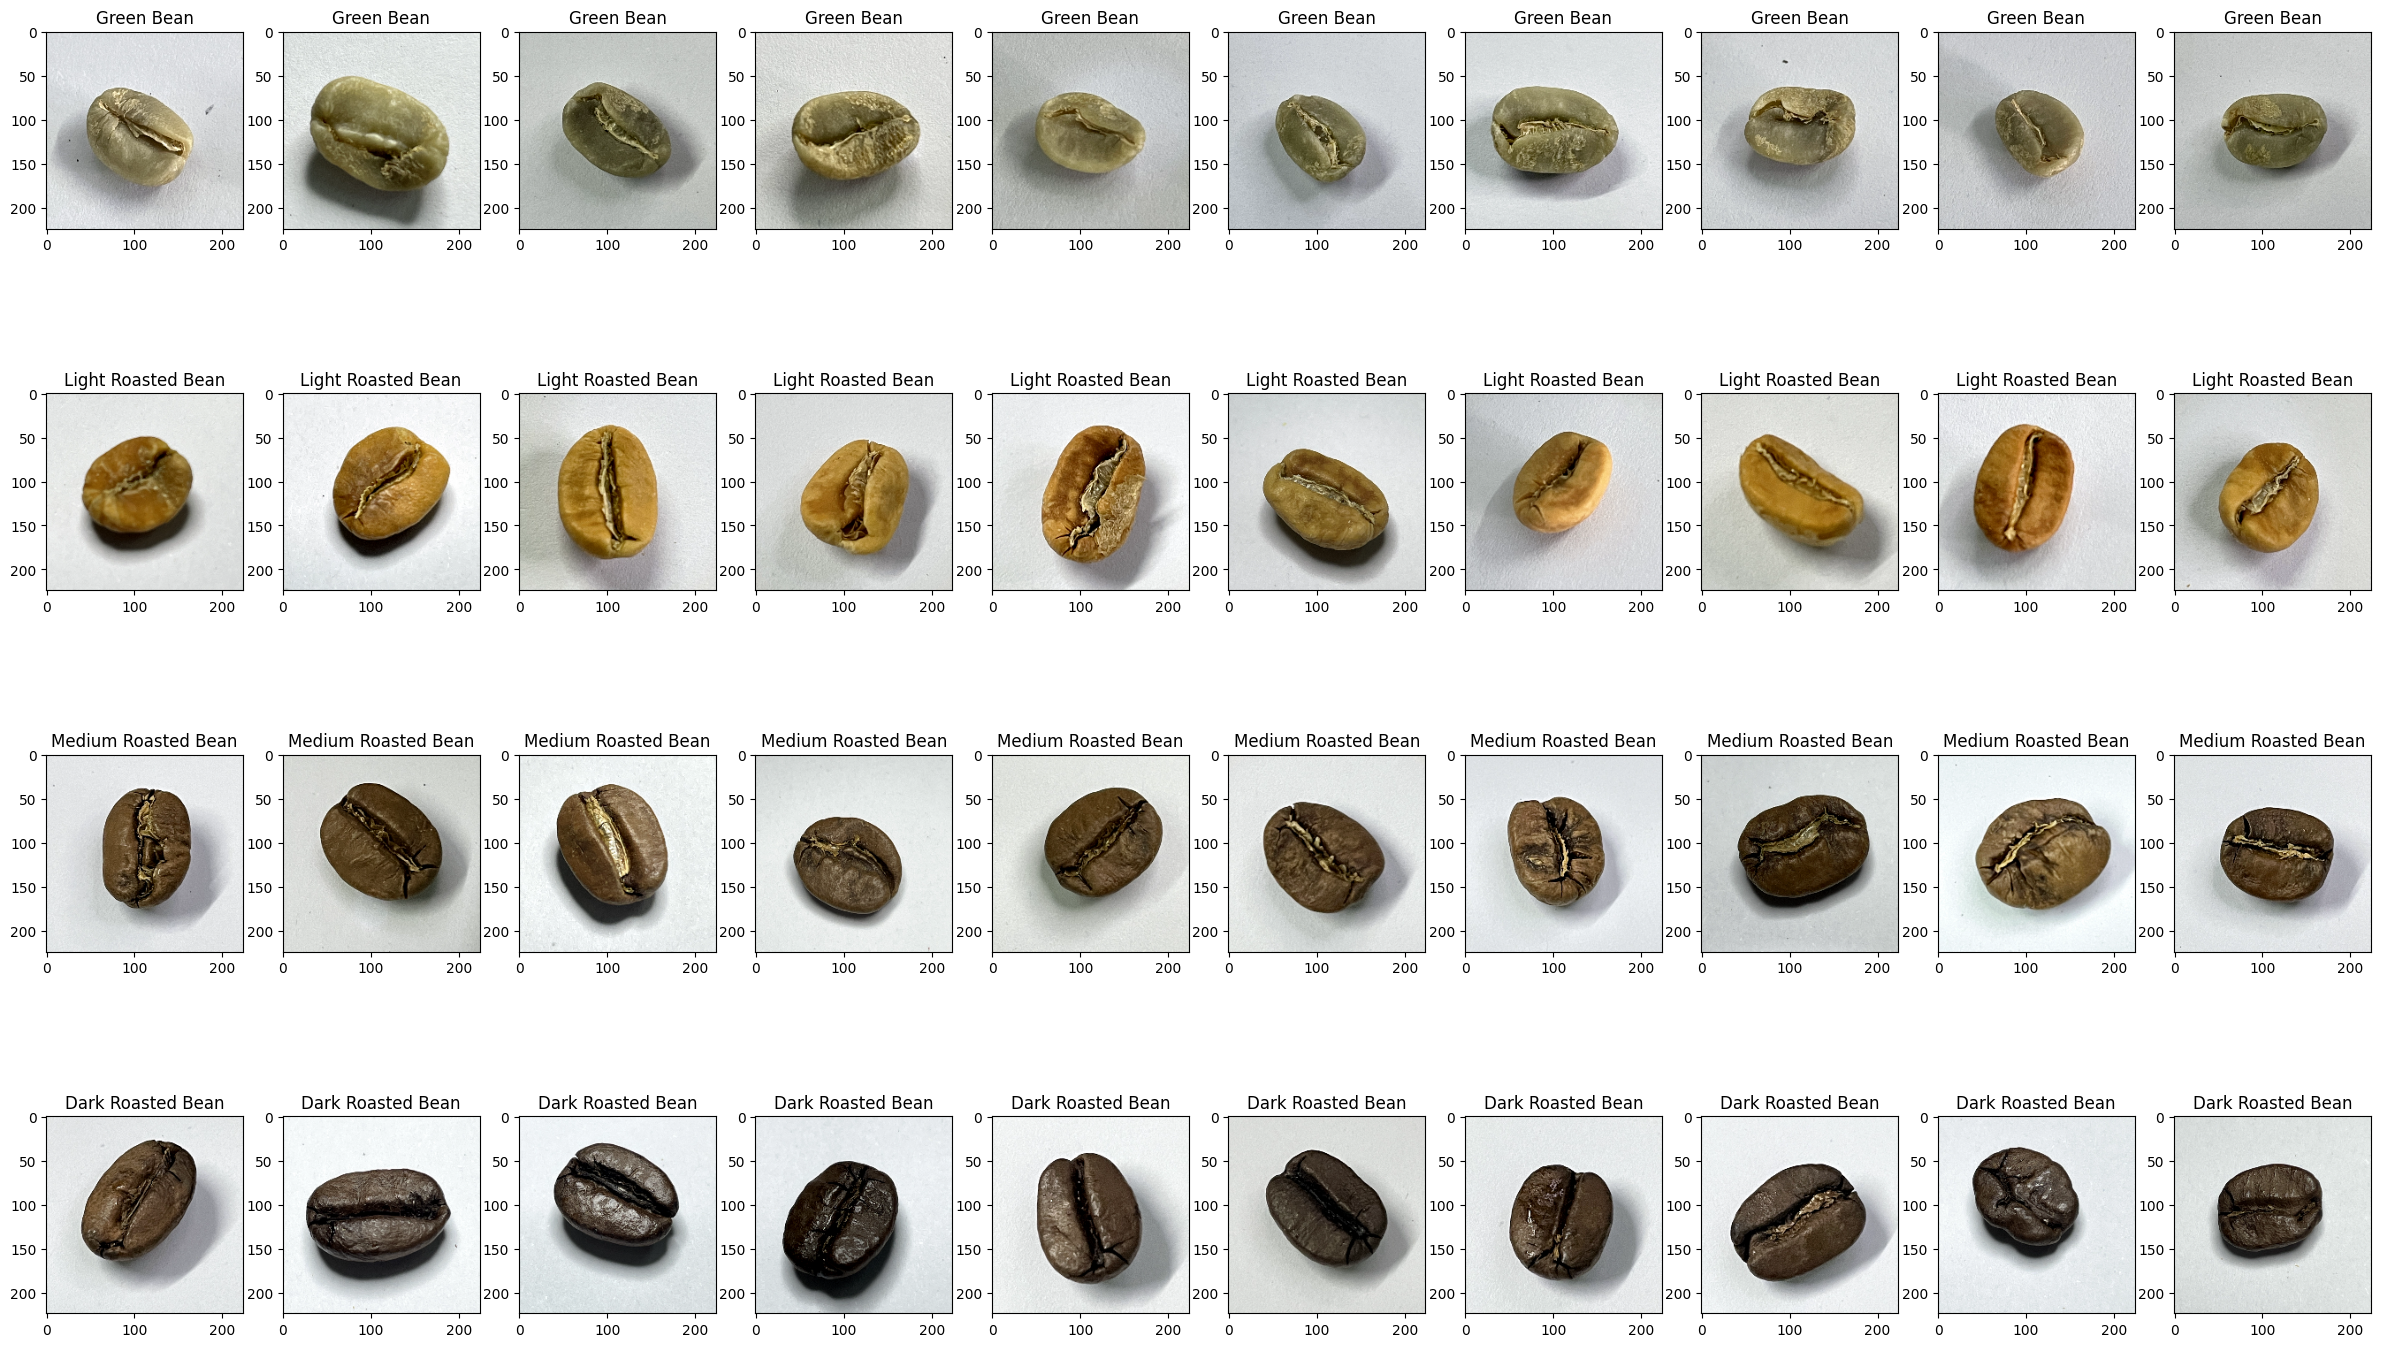

In [5]:
# menampilkan 10 gambar tiap jenis roastingan biji kopi

fig, ax = plt.subplots(nrows=4, ncols=10, figsize=(30, 18))

for i in range(10):
    green = plt.imread(green_files[i])
    ax[0, i].imshow(green)
    ax[0, i].set_title('Green Bean')

    light = plt.imread(light_files[i])
    ax[1, i].imshow(light)
    ax[1, i].set_title('Light Roasted Bean')

    medium = plt.imread(medium_files[i])
    ax[2, i].imshow(medium)
    ax[2, i].set_title('Medium Roasted Bean')

    dark = plt.imread(dark_files[i])
    ax[3, i].imshow(dark)
    ax[3, i].set_title('Dark Roasted Bean')

plt.show()

- Dari hasil tampilan 10 gambar di tiap class terlihat semua gambar sudah memiliki ukuran yang seragam

- Tidak dilakukan proses augmentasi karena data image sudah cukup bervariasi

In [6]:
# loading data dari direktori kaggle untuk ekplorasi data

IMG_SIZE = 224
path = '/content/train/'

datagen = tf.keras.preprocessing.image.ImageDataGenerator()
data = datagen.flow_from_directory(path, (IMG_SIZE, IMG_SIZE), batch_size=32, class_mode='categorical')

Found 1200 images belonging to 4 classes.


Data train memiliki 1200 file. Karena tidak ada data validasi pada dataset maka dari data train ini akan displit sebagian untuk menjadi data validasi. Proses splitting akan dilakukan di langkah selanjutnya.

In [7]:
# mengecek ukuran gambar

data.next()[0].shape

(32, 224, 224, 3)

Gambar pada dataset memiliki ukuran 224x224 dengan sistem layer RGB

In [8]:
# mengecek pelabelan pada class

data.class_indices

{'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}

Dataset memiliki 4 kelas yaitu tipe roastingan biji kopi. Pelabelan dilakukan otomatis oleh komputer sehingga diurutkan berdasarkan alfabet bukan diurutkan berdasarkan tingkat lamanya proses roasting

## Data Preprocessing

In [9]:
#

train_full_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

tf.random.set_seed(34)

train_gen = train_full_datagen.flow_from_directory(
	"/content/train/",
	target_size=(224,224),
	class_mode='categorical',
	subset='training',
  batch_size=32
)
val_gen = train_full_datagen.flow_from_directory(
	"/content/train/",
	target_size=(224,224),
	class_mode='categorical',
	subset='validation',
  batch_size=32, shuffle=False,
)
test_gen = test_datagen.flow_from_directory(
	"/content/test/",
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32, shuffle=False,
)

Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


- Dataset sudah membagi file menjadi train dan test, maka kita tinggal mengakses data gambar dari direktori dataset. Karena akan dibuat juga set data untuk validasi maka dari data train awal 1200 diambil 20% untuk dijadikan data validasi. Data train menjadi 960 dan sekarang kita memiliki data validasi 240

- Karena gambar pada dataset adalah RGB yang memiliki nilai pixel 0-255 maka dilakukan scaling dengan cara membagi data dengan 255 agar input menjadi 0-1

## Model

In [10]:
# membentuk arsitektur model

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

Model terdiri dari beberapa layer yaitu:

- 2 layer konvolusi dengan jumlah filter masing-masing 32 dan 64 dan ukuran filter 3X3. Menggunakan fungsi aktivasi relu agar selalu menghasilkan nilai positif
- 2 layer pooling setelah layer konvolusi dengan ukuran window pooling 2X2
- Layer global average pooling sehingga data berubah jadi vektor
- Layer dengan jumlah neuron 512 dan fungsi aktivasi relu
- Layer output dengan jumlah neuron 4 sesuai dengan jumlah class pada dataset. Menggunakan fungsi aktivasi softmax karena multiclass

In [11]:
# menampilkan rangkuman hasil arsitektur model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

In [12]:
# melakukan compile dan training pada model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_gen, epochs=30, validation_data = val_gen, verbose = 1)

Epoch 1/30
30/30 [==============================] - 19s 149ms/step - loss: 1.3806 - accuracy: 0.2729 - val_loss: 1.3536 - val_accuracy: 0.7208
Epoch 2/30
30/30 [==============================] - 3s 115ms/step - loss: 1.2069 - accuracy: 0.6250 - val_loss: 0.9688 - val_accuracy: 0.6833
Epoch 3/30
30/30 [==============================] - 3s 111ms/step - loss: 0.7544 - accuracy: 0.7542 - val_loss: 0.6235 - val_accuracy: 0.8083
Epoch 4/30
30/30 [==============================] - 4s 144ms/step - loss: 0.4832 - accuracy: 0.8604 - val_loss: 0.4346 - val_accuracy: 0.8708
Epoch 5/30
30/30 [==============================] - 3s 114ms/step - loss: 0.3447 - accuracy: 0.8802 - val_loss: 0.3250 - val_accuracy: 0.9417
Epoch 6/30
30/30 [==============================] - 4s 136ms/step - loss: 0.2587 - accuracy: 0.9146 - val_loss: 0.2941 - val_accuracy: 0.9167
Epoch 7/30
30/30 [==============================] - 5s 152ms/step - loss: 0.1926 - accuracy: 0.9406 - val_loss: 0.1896 - val_accuracy: 0.9583
Epoch

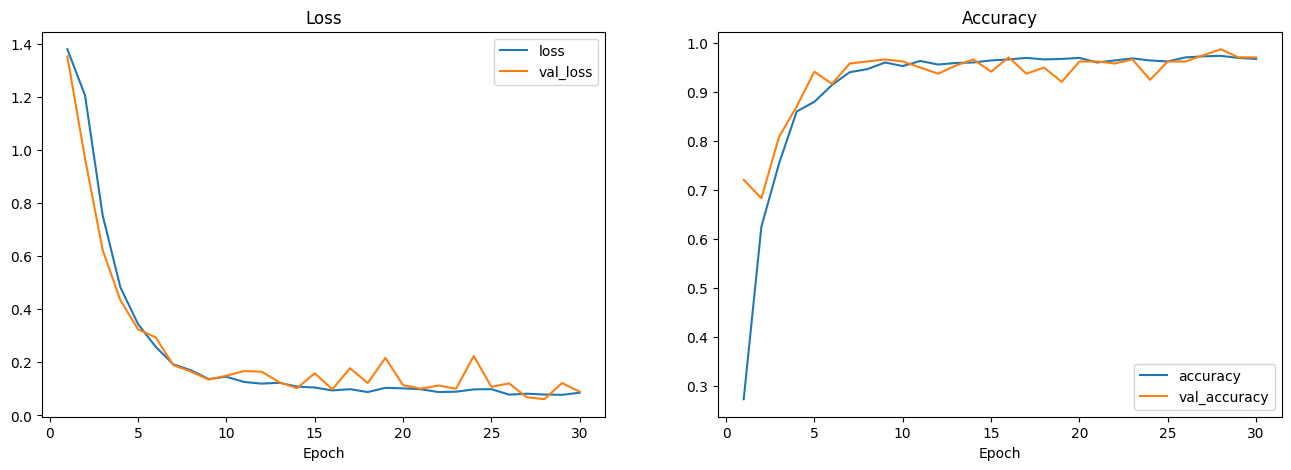

In [13]:
# menampilkan visualisasi loss dan accuracy pada data train dan validasi

epoch=30

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

- Tidak ada vanishing pada loss dan accuracy
- Terdapat explode pada data validasi baik loss ataupun accuracy tetapi jika kita lihat skalanya maka bisa dikatakan kecil
- Model sudah mulai konvergen di epoch ~ 7

## Model Improvement

In [14]:
# membuat arsitektur model improvement

model1 = tf.keras.models.Sequential()

model1.add(tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(224, 224, 3)))
model1.add(tf.keras.layers.MaxPooling2D(2, 2))
model1.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(2, 2))
model1.add(tf.keras.layers.Conv2D(128, (3,3),activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(2, 2))
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(512, activation='relu'))
model1.add(tf.keras.layers.Dense(4, activation='softmax'))

Jika dibandingkan dengan model sebelumnya improvement dilakukan dengan menambahkan :

- Layer konvolusi dengan jumlah filter 128, ukuran filter 3X3, dan fungsi aktivasi relu
- Layer maxpooling dengan window 2X2
- Layer flatten untuk mengubah menjadi vektor sebagai ganti dari global average pooling di model sebelum improvement
- Layer dropout dengan nilai 0,5

In [15]:
# melihat rangkuman arsitektur model improvement

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 128)     

In [16]:
# compile dan training model improvement

model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history1 = model1.fit(train_gen, epochs=30, validation_data = val_gen, verbose = 1)

Epoch 1/30
30/30 [==============================] - 7s 151ms/step - loss: 1.5826 - accuracy: 0.5406 - val_loss: 0.3843 - val_accuracy: 0.8458
Epoch 2/30
30/30 [==============================] - 4s 140ms/step - loss: 0.2589 - accuracy: 0.8979 - val_loss: 0.4146 - val_accuracy: 0.8292
Epoch 3/30
30/30 [==============================] - 5s 165ms/step - loss: 0.1885 - accuracy: 0.9323 - val_loss: 0.1097 - val_accuracy: 0.9667
Epoch 4/30
30/30 [==============================] - 4s 117ms/step - loss: 0.0724 - accuracy: 0.9760 - val_loss: 0.1098 - val_accuracy: 0.9625
Epoch 5/30
30/30 [==============================] - 4s 117ms/step - loss: 0.0397 - accuracy: 0.9854 - val_loss: 0.0742 - val_accuracy: 0.9625
Epoch 6/30
30/30 [==============================] - 5s 155ms/step - loss: 0.0862 - accuracy: 0.9688 - val_loss: 0.0870 - val_accuracy: 0.9708
Epoch 7/30
30/30 [==============================] - 4s 118ms/step - loss: 0.0246 - accuracy: 0.9917 - val_loss: 0.1097 - val_accuracy: 0.9625
Epoch 

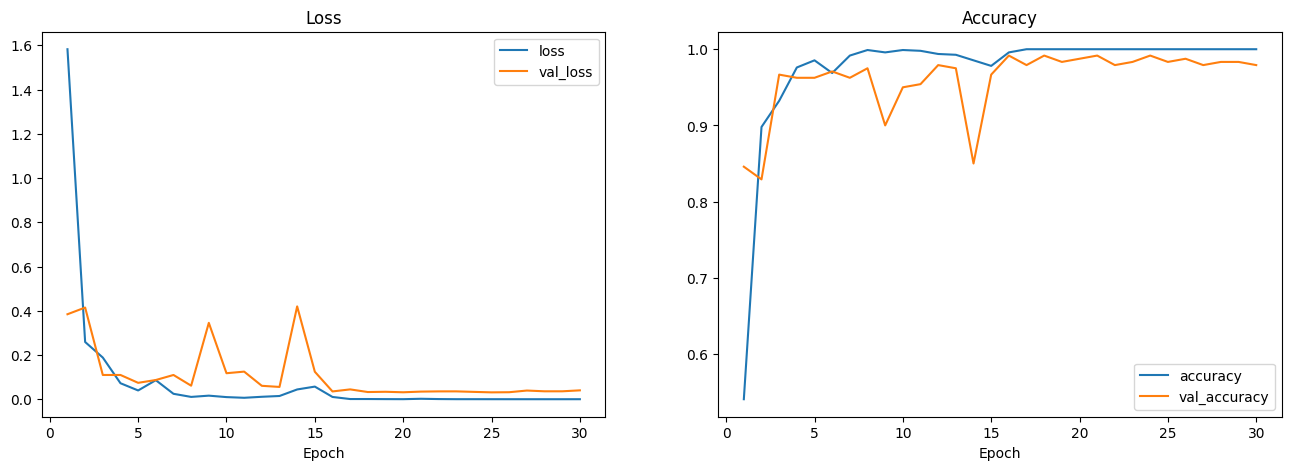

In [17]:
# menampilkan visualisasi loss dan accuracy pada data train dan validasi dari model improvement

epoch=30

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history1.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history1.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history1.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history1.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

- Ada vanishing pada train accuracy di epoch 17
- Ada explode di loss dan accuracy data validasi di epoch 9 dan 14
- Model mulai kovergen di epoch ~ 3

## Model Evaluation

In [18]:
# menampilkan classification report hasil prediksi data test dengan model sebelum improvement

pred = model.predict(test_gen)
pred = np.argmax(pred, axis=1)
true = test_gen.labels

print(classification_report(true,pred))

13/13 [==============================] - 2s 114ms/step
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       100
           1       1.00      1.00      1.00       100
           2       0.97      1.00      0.99       100
           3       0.95      0.93      0.94       100

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



In [19]:
# menampilkan classification report hasil prediksi data test dengan model sesudah improvement

pred1 = model1.predict(test_gen)
pred1 = np.argmax(pred1, axis=1)
true = test_gen.labels

print(classification_report(true,pred1))

13/13 [==============================] - 2s 108ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       0.99      1.00      1.00       100

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [20]:
model.evaluate(test_gen)

13/13 [==============================] - 1s 81ms/step - loss: 0.0841 - accuracy: 0.9700


[0.08408644050359726, 0.9700000286102295]

In [21]:
model1.evaluate(test_gen)

13/13 [==============================] - 1s 84ms/step - loss: 0.0046 - accuracy: 0.9975


[0.0045943185687065125, 0.9975000023841858]

## Model Saving

Berdasarkan hasil evaluasi model maka akan digunakan model hasil improvement sebagai model yang disimpan

In [22]:
model1.save('coffee_predict.h5')

## Model Inference

`Model inference dibuat di notebook terpisah dengan nama file h8dsft_P2M2_Ridhwan_Muttaqien_inference.ipynb`

## Conclusions

Indonesia merupakan salah satu negara penghasil kopi terbesar di dunia, maka wajar jika konsumsi kopi di Indonesia pun juga besar. Berdasarkan data dari International Coffee Organization (ICO), konsumsi kopi di Indonesia memiliki tren kenaikan (sumber : https://dataindonesia.id/agribisnis-kehutanan/detail/berapa-konsumsi-kopi-indonesia-pada-20202021).

Saat ini kopi tidak lagi identik sebagai minuman orang tua, anak muda mulai keranjingan untuk menikmati minuman satu ini. Ini bisa dibuktikan dengan banyaknya cafe atau coffee shop yang bermunculan saat ini. Bahkan tidak jarang penikmat kopi yang menyeduh sendiri di rumah. Mereka hanya perlu memesan biji kopi yang sudah diroasting untuk kemudian digiling dan diseduh sendiri.

Tren menyeduh kopi mandiri ini meningkatkan jumlah penikmat kopi pemula yang baru mulai belajar untuk menikmati minuman pahit ini. Tidak jarang mereka membeli biji kopi tanpa tahu jenis roasting-nya. Milestones 2 ini akan membuat model yang dapat memprediksi jenis roasting pada biji kopi dan juga akan memberi rekomendasi jenis penyeduhan apa yang cocok untuk jenis roasting yang diprediksi. Model ini juga dapat digunakan untuk quality control pada perusahaan roastery kopi.

Model menggunakan data gambar biji kopi sebanyak 1600 gambar yang kemudian dibagi menjadi data train, validasi, dan test. Gambar memiliki ukuran seragam yaitu 224X224 dengan layer RGB. Gambar terbagi menjadi 4 kelas yaitu biji kopi hijau (green), light roasting, medium roasting, dan dark roasting.

Model dibuat dengan arsitektur sequential API menggunakan 2 layer konvolusi dengan jumlah filter masing-masing 32 dan 64, ukuran filter 3X3, dan fungsi aktivasi relu agar selalu menghasilkan nilai positif. Setiap layer konvolusi diikuti dengan layer pooling dengan window 2X2. Kemudian digunakan layer global average pooling agar berubah menjadi vektor untuk kemudian masuk ke layer ANN dengan neuron 512 dan output layer 4 neuron sesuai kelas dari data. Layer output memakai softmax karena klasisikasi multikelas.

Lalu dibuat model kedua dengan menambahkan layer konvolusi pada model sebelumnya dengan jumlah filter 128, ukuran filter 3X3, dan aktivasi relu. Layer konvolusi diikuti dengan layer maxpooling ukuran window 2X2. Ditambahkan juga layer dropout dengan nilai 0.5 serta layer flatten sebagai ganti layer global average pooling.

Hasil evaluasi kedua model dengan menggunakan data test menunjukkan model hasil improvement memiliki performa lebih baik. Maka model yang disimpan untuk kemudian dicoba dengan data baru adalah model hasil improvement.

Berdasarkan hasil prediksi dengan data baru didapatkan kesalahan prediksi. Dimana model salah memprediksi antara light roasting dan medium roasting. Ini bisa disebabkan karena perbedaan warna yang tidak terlalu jelas antara light dan medium roasting. Tingkat kecerahan gambar pada data inference juga bisa berpengaruh mengakibatkan salah prediksi. Data input model adalah data yang seragam baik jumlah biji kopi pada gambar, ukuran gambar, background gambar, bahkan kamera yang digunakan serta lingkungan pengambilan gambar dibuat dengan pencahayaan yang sama. Sehingga ketika kita mencoba memprediksi dengan data lain yang berbeda ukuran, background, pencahayaan, dan kualitas kamera yang digunakan, ada kemungkinan model salah memprediksi.

Model masih dapat ditingkatkan dengan menambahkan jumlah dataset yang lebih bervariasi seperti menambahkan data gambar dengan jumlah biji kopi yang lebih banyak di satu gambar. Bisa juga dilakukan proses augmentasi pada data input. Kita juga bisa mengatur tingkat kecerahan data inference sehingga mirip dengan kecerahan dataset yang kita gunakan.